In [9]:
# load packages and data
library(data.table) 
library(ggplot2)
library(dplyr) # if not installed locally, in command prompt use "conda install -c r r-dplyr"

# change deafult plot sizes
options(repr.plot.width=4, repr.plot.height=3)

# load data
loadDir = './Data/' # set directory where data will be loaded from
loadFName = 'Make 18_full.csv' # set file name of Qualtrics csv
rawData <- data.table::fread(input = paste(loadDir, loadFName, sep=''))

# also load in data from AMT to match MIDs (to download: on AMT site > Review Results > Download CSV)
amtIDs = data.table::fread(input = paste(loadDir, 'Make 18_full_AMT.csv' , sep=''), select='WorkerId') 

dataStartRow = 75 # set the row number when full experiment starts (used to exclude MIDs from past pilot runs)


Warning message in data.table::fread(input = paste(loadDir, "Make 18_full_AMT.csv", :
"Detected 30 column names but the data has 28 columns. Filling rows automatically. Set fill=TRUE explicitly to avoid this warning."

In [3]:
head(rawData)

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random
Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random
"{""""ImportId"""":""""startDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""endDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""status""""}","{""""ImportId"""":""""ipAddress""""}","{""""ImportId"""":""""progress""""}","{""""ImportId"""":""""duration""""}","{""""ImportId"""":""""finished""""}","{""""ImportId"""":""""recordedDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""_recordId""""}","{""""ImportId"""":""""recipientLastName""""}",...,"{""""ImportId"""":""""q1_txt""""}","{""""ImportId"""":""""q2_txt""""}","{""""ImportId"""":""""q3_txt""""}","{""""ImportId"""":""""q4_txt""""}","{""""ImportId"""":""""q5_txt""""}","{""""ImportId"""":""""surveycode""""}","{""""ImportId"""":""""MID""""}","{""""ImportId"""":""""p1_txt""""}","{""""ImportId"""":""""p2_txt""""}","{""""ImportId"""":""""Random""""}"
2021-07-09 22:36:19,2021-07-09 22:37:51,Survey Preview,,100,91,True,2021-07-09 22:37:54,R_2YhLYlwEGxfIgCh,,...,NaN(5+7)*(10-8),NaN(11+13)*(6-5),NaN3+7*2,NaN10+8-7-5,NaN2+3+5+8,9348,,,,2
2021-07-09 22:39:36,2021-07-09 22:53:16,IP Address,157.51.62.60,100,820,True,2021-07-09 22:53:17,R_2e4IILDq5qEipzH,,...,NaN10+8/(6-7),NaN13+5,NaN7*2+(1*4),,NaN8*3-(5+7),1441,A33Z442WJQ8ADC,,,2
2021-07-09 22:38:07,2021-07-09 22:54:39,IP Address,201.47.22.214,100,992,True,2021-07-09 22:54:40,R_2U5fS9EqxPKlcze,,...,NaN3*6*(8-7),NaN5*6*(11-13),NaN2*7*(4-1),NaN3*7*(7-2),~+3*8*(2-5),7876,A2825I2XO6KZEP,,,1
2021-07-09 22:54:07,2021-07-09 23:00:33,IP Address,192.154.206.9,100,385,True,2021-07-09 23:00:34,R_1k0TzyF95z6apGi,,...,NaN33.6,NaN11+13+5/6,NaN1/2*4*7,NaN7/3*7*2,NaN2/8*3+5,9853,A35T79LLCN429G,,,2


In [18]:
# basic removals
cleanedData = rawData[-(1:dataStartRow), ] # remove all data from previous pilot runs
cleanedData = cleanedData[MID %in% amtIDs[, WorkerId], ] # keep only entries with AMT worker IDs that match those on Amazon interface
cleanedData = cleanedData[order(StartDate)] # reorder by ascending starting time

# print repeated IPs and MIDs
print('Repeated IPs:')
data.table(table(c(cleanedData[, IPAddress], 000)))[N>1, ]
print('Repeated MIDs:')
data.table(table(c(cleanedData[, MID], 000)))[N>1, ]

# remove repeated IPs and MIDs
repeatedIPs = data.table(table(c(cleanedData[, IPAddress], 000)))[N>1, V1]
repeatedMIDs = data.table(table(c(cleanedData[, MID], 000)))[N>1, V1]

for (MID_i in repeatedMIDs) {
    cleanedData[which(cleanedData[, MID] == MID_i)[-1], ] = NA # remove data from duplicate MechTurk IDs (keep first data point)
}
for (IP_i in repeatedIPs) {
    cleanedData[which(cleanedData[, IPAddress] == IP_i)[-1], ] = NA # remove data from duplicate IPs (keep first data point)
}
cleanedData = na.omit(cleanedData)

'cleanedData Dimensions:'
dim(cleanedData)

[1] "Repeated IPs:"


V1,N
117.213.35.151,2
117.213.35.153,3
117.217.160.22,2
117.217.212.77,2
182.65.18.62,2
49.37.209.192,3
49.37.211.26,3
59.99.222.64,2


[1] "Repeated MIDs:"


V1,N
AFV9RX3T7ZHIB,2


[1] "cleanedData Dimensions:"

[1] 274 179

In [13]:
head(cleanedData)

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random
2021-07-26 07:02:06,2021-07-26 07:05:13,IP Address,71.45.159.14,100,186,True,2021-07-26 07:05:13,R_XnOVJROn5tCCasN,,...,q~10,q~5,q~4,q~3,q~5,8348,A2MNDXS4E8LRJR,p~10~10/10*9*2,p~7~3*6*(8-7),1
2021-07-26 07:01:13,2021-07-26 07:05:58,IP Address,76.72.175.120,100,285,True,2021-07-26 07:05:59,R_2oBfPD8TrFxLuGl,,...,q~6*10*(8-1),q~11*13*(6-1),q~1*(2/4)*7,q~7/7*3+2,q~2+8*3/5,9024,A33S7UYXRIGYDR,p~31~10/10*9*2,p~8/6*7*3~3*6*(8-7),1
2021-07-26 07:02:42,2021-07-26 07:06:54,IP Address,185.196.25.144,100,252,True,2021-07-26 07:06:54,R_2wt2jiF8Z9JnQpt,,...,q~31,q~35,q~14,q~19,q~18,1589,A3IKNT1N18NMNB,p~31~10/10*9*2,p~24~3*6*(8-7),1
2021-07-26 07:03:51,2021-07-26 07:06:56,IP Address,68.9.42.46,100,184,True,2021-07-26 07:06:56,R_2zvbpGaGGBQCN7E,,...,q~6*10+7*8,q~11*13*5+6,q~1*2*(4+7),q~7*3+7-2,q~2*8*3+5,3224,A3HZFB2JLF3JMY,p~8~10/10*9*2,p~9~3*6*(8-7),2
2021-07-26 07:02:41,2021-07-26 07:07:15,IP Address,12.198.49.144,100,273,True,2021-07-26 07:07:15,R_1gI8cou5BKsoBIw,,...,q~520,q~15,q~14,q~19,q~15,1561,A18F0VDH08E0QY,p~31~10/10*9*2,p~50~3*6*(8-7),1
2021-07-26 07:02:06,2021-07-26 07:07:27,IP Address,74.137.215.201,100,321,True,2021-07-26 07:07:27,R_1pVXrRgaOTRkzF6,,...,q~6-10/7*8,q~11+3/5-6,q~1+2*4/7,q~7*3/7+2,q~2*8/3*5,6639,A3E2TLUKGTFGLO,p~2-10+9/10~10/10*9*2,p~3+6/7*8~3*6*(8-7),1


In [20]:
# check if any subjects did not finish the survey

cleanedData[Finished=='False', ]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,q1_txt,q2_txt,q3_txt,q4_txt,q5_txt,surveycode,MID,p1_txt,p2_txt,Random


In [21]:
# print all raw column names
names(cleanedData)

[1] "StartDate"                 "EndDate"                  
  [3] "Status"                    "IPAddress"                
  [5] "Progress"                  "Duration (in seconds)"    
  [7] "Finished"                  "RecordedDate"             
  [9] "ResponseId"                "RecipientLastName"        
 [11] "RecipientFirstName"        "RecipientEmail"           
 [13] "ExternalReference"         "LocationLatitude"         
 [15] "LocationLongitude"         "DistributionChannel"      
 [17] "UserLanguage"              "Q_RecaptchaScore"         
 [19] "Q_RecaptchaAssessmentName" "Q1.1_First Click"         
 [21] "Q1.1_Last Click"           "Q1.1_Page Submit"         
 [23] "Q1.1_Click Count"          "Q2.1"                     
 [25] "Q2.1_3_TEXT"               "Q2.2"                     
 [27] "Q2.3"                      "Q2.3_7_TEXT"              
 [29] "Q2.4"                      "Q2.5"                     
 [31] "Q2.6"                      "Q2.7_1"                   
 [33] "Q3.1_First Click"          "Q3.1_Last Click"          
 [35] "Q3.1_Page Submit"          "Q3.1_Click Count"         
 [37] "Q4.1_First Click"          "Q4.1_Last Click"          
 [39] "Q4.1_Page Submit"          "Q4.1_Click Count"         
 [41] "Q4.3_First Click"          "Q4.3_Last Click"          
 [43] "Q4.3_Page Submit"          "Q4.3_Click Count"         
 [45] "Q5.1_First Click"          "Q5.1_Last Click"          
 [47] "Q5.1_Page Submit"          "Q5.1_Click Count"         
 [49] "Q6.1_First Click"          "Q6.1_Last Click"          
 [51] "Q6.1_Page Submit"          "Q6.1_Click Count"         
 [53] "Q6.3_First Click"          "Q6.3_Last Click"          
 [55] "Q6.3_Page Submit"          "Q6.3_Click Count"         
 [57] "Q6.4_1"                    "Q6.5_1"                   
 [59] "Q6.6_First Click"          "Q6.6_Last Click"          
 [61] "Q6.6_Page Submit"          "Q6.6_Click Count"         
 [63] "Q6.8_First Click"          "Q6.8_Last Click"          
 [65] "Q6.8_Page Submit"          "Q6.8_Click Count"         
 [67] "Q6.9_1"                    "Q6.10_1"                  
 [69] "Q6.11_First Click"         "Q6.11_Last Click"         
 [71] "Q6.11_Page Submit"         "Q6.11_Click Count"        
 [73] "Q6.13_First Click"         "Q6.13_Last Click"         
 [75] "Q6.13_Page Submit"         "Q6.13_Click Count"        
 [77] "Q6.14_1"                   "Q6.15_1"                  
 [79] "Q6.16_First Click"         "Q6.16_Last Click"         
 [81] "Q6.16_Page Submit"         "Q6.16_Click Count"        
 [83] "Q6.18_First Click"         "Q6.18_Last Click"         
 [85] "Q6.18_Page Submit"         "Q6.18_Click Count"        
 [87] "Q6.19_1"                   "Q6.20_1"                  
 [89] "Q6.21_First Click"         "Q6.21_Last Click"         
 [91] "Q6.21_Page Submit"         "Q6.21_Click Count"        
 [93] "Q6.23_First Click"         "Q6.23_Last Click"         
 [95] "Q6.23_Page Submit"         "Q6.23_Click Count"        
 [97] "Q6.24_1"                   "Q6.25_1"                  
 [99] "Q7.1_First Click"          "Q7.1_Last Click"          
[101] "Q7.1_Page Submit"          "Q7.1_Click Count"         
[103] "Q8.1_First Click"          "Q8.1_Last Click"          
[105] "Q8.1_Page Submit"          "Q8.1_Click Count"         
[107] "Q8.3_First Click"          "Q8.3_Last Click"          
[109] "Q8.3_Page Submit"          "Q8.3_Click Count"         
[111] "Q8.4_1"                    "Q8.5_1"                   
[113] "Q8.6_First Click"          "Q8.6_Last Click"          
[115] "Q8.6_Page Submit"          "Q8.6_Click Count"         
[117] "Q8.8_First Click"          "Q8.8_Last Click"          
[119] "Q8.8_Page Submit"          "Q8.8_Click Count"         
[121] "Q8.9_1"                    "Q8.10_1"                  
[123] "Q8.11_First Click"         "Q8.11_Last Click"         
[125] "Q8.11_Page Submit"         "Q8.11_Click Count"        
[127] "Q8.13_First Click"         "Q8.13_Last Click"         
[129] "Q8.13_Page Submit"         

In [22]:
# coalesce control and treatment data into combined columns

numPuzzles = 5

defaultW <- getOption("warn") # suppress warnings that appear when coalescing
options(warn=-1)

# for each puzzle, coalesce the data (text and stress/confidence questions) from treatment and control into a single column
for (puzzleNum in c(1:numPuzzles)) {
    # create column names to get data from in each loop (i.e. for each puzzle)
    rt_colName_treat = paste('Q6.', toString(1+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_colName_control = paste('Q8.', toString(1+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_questions_colName_treat = paste('Q6.', toString(3+(puzzleNum-1)*5), '_Page Submit', sep='')
    rt_questions_colName_control = paste('Q8.', toString(3+(puzzleNum-1)*5), '_Page Submit', sep='')
    stress_colName_treat = paste('Q6.', toString(4+(puzzleNum-1)*5), '_1', sep='')
    stress_colName_control = paste('Q8.', toString(4+(puzzleNum-1)*5), '_1', sep='')
    confidence_colName_treat = paste('Q6.', toString(5+(puzzleNum-1)*5), '_1', sep='')
    confidence_colName_control = paste('Q8.', toString(5+(puzzleNum-1)*5), '_1', sep='')
    
    # coalesce the data for each puzzle question
    cleanedData[, paste('rt_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..rt_colName_treat])), as.numeric(unlist(cleanedData[, ..rt_colName_control])))]
    cleanedData[, paste('rt_questions_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..rt_questions_colName_treat])), as.numeric(unlist(cleanedData[, ..rt_questions_colName_control])))]
    cleanedData[, paste('stress_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..stress_colName_treat])), as.numeric(unlist(cleanedData[, ..stress_colName_control])))]
    cleanedData[, paste('confidence_q', puzzleNum , sep=''):=coalesce(as.numeric(unlist(cleanedData[, ..confidence_colName_treat])), as.numeric(unlist(cleanedData[, ..confidence_colName_control])))]  
}

options(warn = defaultW)


# coalesce for treatment message page
cleanedData[, 'rt_treatMsg':=coalesce(as.numeric(unlist(cleanedData[, 'Q5.1_Page Submit'])), as.numeric(unlist(cleanedData[, 'Q7.1_Page Submit'])))]
cleanedData[, 'cc_treatMsg':=coalesce(as.numeric(unlist(cleanedData[, 'Q5.1_Click Count'])), as.numeric(unlist(cleanedData[, 'Q7.1_Click Count'])))]


### Rename Column Names (can be customized)

In [23]:
# rename columns

# rt = response time, cc = click count
##### change the key below if you want to use different column names:
renamedCols = c('IPAddress'='IP', 'Duration (in seconds)'='totTaskTime',
                'Q1.1_Page Submit'='rt_intro', 'Q1.1_Click Count'='cc_intro',
                'Q2.1'='gender', 'Q2.2'='age', 'Q2.3'='ethnicity', 'Q2.4'='education', 'Q2.5'='income', 'Q2.6'='intent', 'Q2.7_1'='mathEnjoyment',
                'Q3.1_Page Submit'='rt_instructions', 'Q3.1_Click Count'='cc_instructions', 
                'Q4.1_Page Submit'='rt_prac1', 'Q4.1_Click Count'='cc_prac1', 'p1_txt'='text_prac1',
                'Q4.3_Page Submit'='rt_prac2', 'Q4.3_Click Count'='cc_prac2', 'p2_txt'='text_prac2',
                'q1_txt'='text_q1', 'q2_txt'='text_q2', 'q3_txt'='text_q3', 'q4_txt'='text_q4', 'q5_txt'='text_q5', 
                'Q9.1'='postq_playedBefore', 'Q9.2_1'='postq_enjoy', 'Q9.3_1'='postq_difficulty', 'Q9.4_1'='postq_focus', 'Q9.5_1'='postq_pressure',
                'Q9.6'='postq_impact', 'Q11.1'='freeResponse',
                'Random'='treatGroup'
               )


# rename columns according to key above
for (colNum in 1:length(renamedCols)) {
    setnames(cleanedData, names(renamedCols[colNum]), toString(renamedCols[colNum]))
}

### Helper Functions for Exlcuding Subjects

In [24]:
# function for comparing inputted numbers with those given by the puzzle
# getting only the inputted numeric values is kind of contrived 
# because we need to differentiate between '10" as '10' and not '1' and '0'
# we do this by going through each character and checking if the character after each number is also a number or not

checkDigits = function (inputStr, puzzleNums) {
    allChars = unlist(strsplit(inputStr, split = ""))
    
    inputtedNums = c()

    defaultW <- getOption("warn") # suppress warnings that appear when coalescing
    options(warn=-1)
    
    for (charNum in 1:length(allChars)) {
        if (all(c(is.na(as.numeric(allChars[charNum - 1])), TRUE))) { # only collect numbers when previous character is not a number
            currChar = allChars[charNum]

            if (charNum == length(allChars)) { # no next character at end of list
                nextChar = NA
            } else {
                nextChar = allChars[charNum + 1]     
            }

            # numbers inputted next to each other are counted as a single number (eg. 10 is '10' and not '1' and '0')
            if (!is.na(as.numeric(currChar))) {
                if (!is.na(as.numeric(currChar)) & !is.na(as.numeric(nextChar))) {
                    inputtedNums = c(inputtedNums, as.numeric(paste(currChar, nextChar, sep='')))
                } else {
                    inputtedNums = c(inputtedNums, as.numeric(currChar))  
                }
            }
        }
    }

    options(warn = defaultW)
    
    
    
    # check if subject's input contains all 4 of the numbers given in the puzzle
    length(inputtedNums)==length(puzzleNums) & setequal(inputtedNums, puzzleNums)
}


# function for extracting all text before the correct answer is given in practice questions
extractPracText = function (inputStr) {
    allChars = unlist(strsplit(inputStr, split = ""))
    tildeInds = unlist(gregexpr(pattern ='~', inputStr))
    
    if (length(tildeInds)==1) { # if the subject answered correctly output the entire string
         inputStr
    } else { # if answered incorrectly, output only characters before the 2nd tilde
        paste(allChars[1:tildeInds[2]], collapse='') 
    }
}

### Exclude subjects based on exclusion criteria

In [25]:
# create new columns with extracted practice question text
cleanedData[, 'text_prac1_extracted':=apply(cleanedData[, 'text_prac1'], 1, extractPracText)]
cleanedData[, 'text_prac2_extracted':=apply(cleanedData[, 'text_prac2'], 1, extractPracText)]

In [26]:
# exclude subjects based on exclusion criteria

allPuzzleNums = list('prac1' = c(2,10,9,10), 'prac2' = c(3,6,7,8),
                     'q1' = c(6,10,7,8), 'q2' = c(11,13,5,6), 'q3' = c(1,2,4,7), 'q4' = c(7,3,7,3), 'q5' = c(2,8,3,5)
                    )

# exclusion criteria: 
# 1. across all practice and test puzzles, at least one of them uses all 4 puzzle numbers in the attempted response

cleanedData = cleanedData[apply(cleanedData[, 'text_prac1_extracted'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['prac1'])) |
                apply(cleanedData[, 'text_prac2_extracted'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['prac2'])) |
                apply(cleanedData[, 'text_q1'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['q1'])) |
                apply(cleanedData[, 'text_q2'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['q2'])) |
                apply(cleanedData[, 'text_q3'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['q3'])) |
                apply(cleanedData[, 'text_q4'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['q4'])) |
                apply(cleanedData[, 'text_q5'], 1, checkDigits, puzzleNums=unlist(allPuzzleNums['q5'])), ]

# EDA

In [27]:
# subset to only columns that will be used for analysis

colsForAnalysis = c('totTaskTime', 'UserLanguage', 
                    'rt_intro', 'cc_intro',
                    'gender', 'age', 'ethnicity', 'education', 'income', 'intent', 'mathEnjoyment',
                    'rt_instructions', 'cc_instructions', 
                    'rt_prac1', 'cc_prac1', 'text_prac1',
                    'rt_prac2', 'cc_prac2', 'text_prac2',
                    'rt_treatMsg', 'cc_treatMsg',
                    'rt_q1', 'rt_questions_q1', 'stress_q1', 'confidence_q1',
                    'rt_q2', 'rt_questions_q2', 'stress_q2', 'confidence_q2',
                    'rt_q3', 'rt_questions_q3', 'stress_q3', 'confidence_q3',
                    'rt_q4', 'rt_questions_q4', 'stress_q4', 'confidence_q4',
                    'rt_q5', 'rt_questions_q5', 'stress_q5', 'confidence_q5',
                    'q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'final_score', 'true_earnings',
                    'postq_playedBefore', 'postq_enjoy', 'postq_difficulty', 'postq_focus', 'postq_pressure',
                    'postq_impact', 'freeResponse',
                    'treatGroup',
                    'MID'
                   )

cleanedData = cleanedData[ , ..colsForAnalysis] 

In [29]:
print('Sample Sizes By Treatment Group:')
table(cleanedData[, treatGroup])

[1] "Sample Sizes By Treatment Group:"



  1   2 
 99 102 

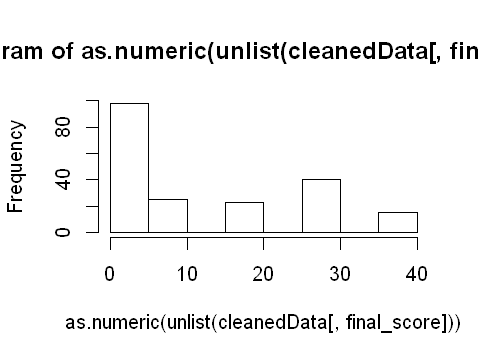

In [30]:
hist(as.numeric(unlist(cleanedData[, final_score])))

In [23]:
lm_basic = cleanedData[ , lm(final_score~as.numeric(treatGroup))]
summary(lm_basic)


Call:
lm(formula = final_score ~ as.numeric(treatGroup))

Residuals:
    Min      1Q  Median      3Q     Max 
-13.535 -11.471  -3.535  16.465  28.529 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              15.600      3.182   4.902 1.96e-06 ***
as.numeric(treatGroup)   -2.065      2.004  -1.030    0.304    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.2 on 199 degrees of freedom
Multiple R-squared:  0.005307,	Adjusted R-squared:  0.0003088 
F-statistic: 1.062 on 1 and 199 DF,  p-value: 0.3041


In [24]:
lmTreatment = cleanedData[ , lm(final_score~as.numeric(treatGroup) + ethnicity + education + income + intent)]
summary(lmTreatment)


Call:
lm(formula = final_score ~ as.numeric(treatGroup) + ethnicity + 
    education + income + intent)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.564  -9.452  -3.426   9.867  33.063 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         7.69529    4.18095   1.841   0.0673 .  
as.numeric(treatGroup)             -2.13445    1.91127  -1.117   0.2655    
ethnicityAsian                     15.33023    3.51059   4.367 2.08e-05 ***
ethnicityHispanic                  16.56681    8.15003   2.033   0.0435 *  
ethnicityNative American           -1.60842    7.15548  -0.225   0.8224    
ethnicityPrefer not to answer       5.69219   10.40457   0.547   0.5850    
ethnicityWhite/ Caucasian           3.93580    3.05990   1.286   0.1999    
educationHigh school                8.09028    6.09024   1.328   0.1857    
educationMaster's or higher degree  1.37618    2.42370   0.568   0.5709    
income$50,000 - $100,000  

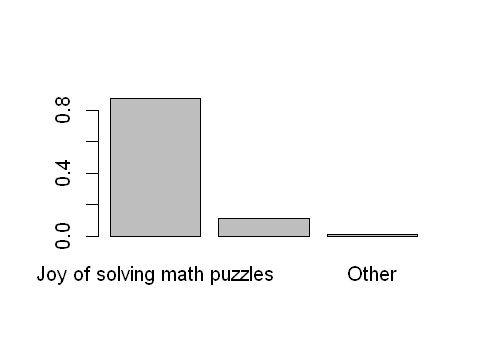

In [245]:
barplot(prop.table(table(cleanedData[, intent])))

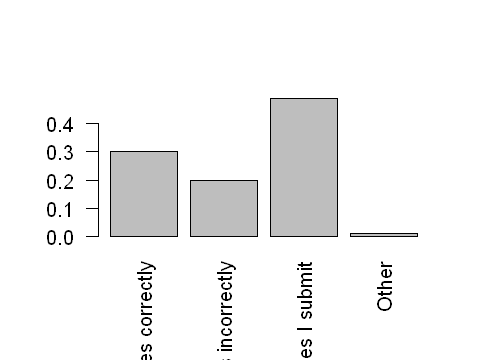

In [253]:
barplot(prop.table(table(cleanedData[, postq_impact])), las=2)

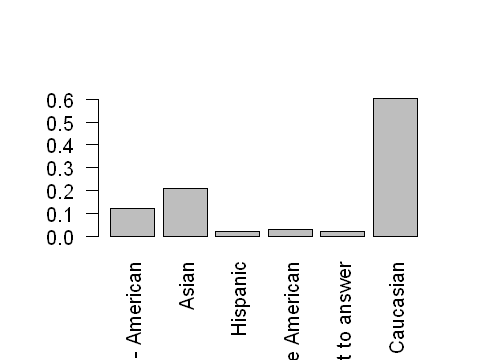

In [258]:
barplot(prop.table(table(cleanedData[, ethnicity])), las=2)